In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import glob
import numpy as np
import xgboost as xgb


In [159]:
cornbelters_files = glob.glob("../KCLData/*.csv")
other_files = glob.glob("../CornBeltersData/*.csv")

all_files = cornbelters_files + other_files

# Read and concatenate all CSVs into one DataFrame
stuff_plus = [pd.read_csv(f) for f in all_files]
df = pd.concat(stuff_plus, ignore_index=True)


In [160]:
dft = df[['PlayResult','RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak','VertApprAngle']]

In [161]:
dft['PlayResult'].unique()


array([nan, 'StrikeoutLooking', 'StrikeoutSwinging', 'Out', 'Single',
       'Walk', 'Error', 'Double', 'Triple', 'HomeRun', 'FieldersChoice',
       'Sacrifice', 'HItByPitch'], dtype=object)

In [162]:
dft = dft.dropna()

In [163]:
map_data = {
    'StrikeoutLooking': 1,
    'StrikeoutSwinging': 1,
    'Out': 1,
    'Single': 0,
    'Double': -1,
    'Error': 0,
    'Walk': 0,
    'Triple': -1,
    'HomeRun': -1,
    'FieldersChoice': 0,
    'Sacrifice': 0,
    'HitByPitch' : 0,
    'HItByPitch' : 0
}

dft['PlayResult'] = dft['PlayResult'].map(map_data)

In [164]:
dft.to_csv('nan.csv')

In [165]:
print("Unmapped values:", dft['PlayResult'].isna().sum())
print(df[~df['PlayResult'].isin(map_data.keys())]['PlayResult'].unique())

Unmapped values: 0
[nan]


In [166]:
features = ['RelSpeed','SpinRate','RelHeight','RelSide','Extension','InducedVertBreak', 'HorzBreak']

In [167]:
X = dft[features]
y = dft['PlayResult']


In [168]:
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from math import sqrt
# Define the XGBoost Regressor model
xgb_model_rand = xgb.XGBRegressor(objective='reg:squarederror',
                                  eval_metric='rmse',
                                  random_state=42)

# Define the parameter distributions to sample from
param_distributions = {
    'n_estimators': randint(100, 500), # Integer distribution
    'learning_rate': uniform(0.01, 0.2), # Continuous distribution from 0.01 to 0.21
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 6),
    'subsample': uniform(0.6, 0.4), # From 0.6 to 1.0 (0.6 + 0.4)
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.1),
    'reg_lambda': uniform(0, 1)
}

# Set up RandomizedSearchCV
# n_iter: Number of parameter settings that are sampled.
random_search = RandomizedSearchCV(estimator=xgb_model_rand,
                                   param_distributions=param_distributions,
                                   n_iter=50, # Try 50 different combinations
                                   cv=KFold(n_splits=5, shuffle=True, random_state=42),
                                   scoring='neg_mean_squared_error',
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Fit the RandomizedSearchCV object to your data
print("\nStarting RandomizedSearchCV...")
random_search.fit(X, y)

# Get the best parameters and best score
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation RMSE: {sqrt(-random_search.best_score_)}")


Starting RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'colsample_bytree': np.float64(0.8363571772752967), 'gamma': np.float64(0.3387821809211412), 'learning_rate': np.float64(0.013317565785571231), 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 247, 'reg_alpha': np.float64(0.064517279040945), 'reg_lambda': np.float64(0.17436642900499144), 'subsample': np.float64(0.8763750952409863)}
Best cross-validation RMSE: 0.6099029699136602


In [169]:
xgb_model = xgb.XGBRegressor(best_params_=random_search.best_params_,)
xgb_model.fit(X, y)


XGBRegressor(base_score=None,
             best_params_={'colsample_bytree': np.float64(0.8363571772752967),
                           'gamma': np.float64(0.3387821809211412),
                           'learning_rate': np.float64(0.013317565785571231),
                           'max_depth': 5, 'min_child_weight': 3,
                           'n_estimators': 247,
                           'reg_alpha': np.float64(0.064517279040945),
                           'reg_lambda': np.float64(0.17436642900499144),
                           'subsample': np.float64(0.876...
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [170]:
from itertools import product

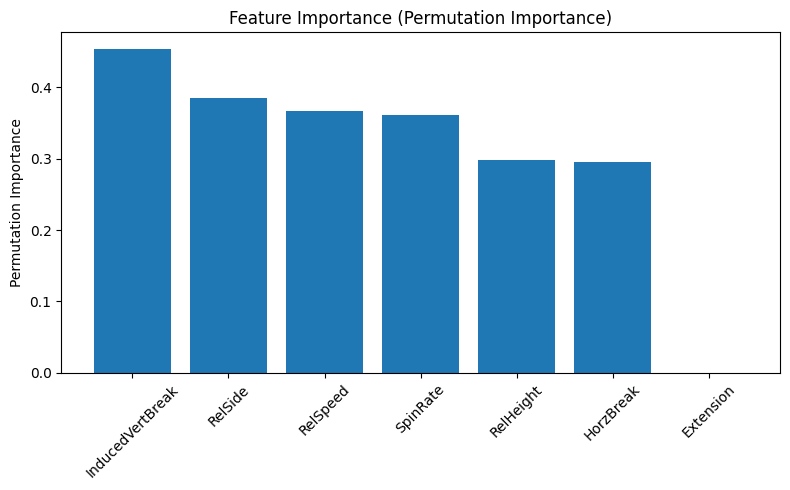

In [171]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance
result = permutation_importance(xgb_model, X, y, n_repeats=10, random_state=42)

# Get importances and sort
importances = result.importances_mean
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(8,5))
plt.bar(range(len(features)), importances[indices])
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=45)
plt.ylabel("Permutation Importance")
plt.title("Feature Importance (Permutation Importance)")
plt.tight_layout()
plt.show()

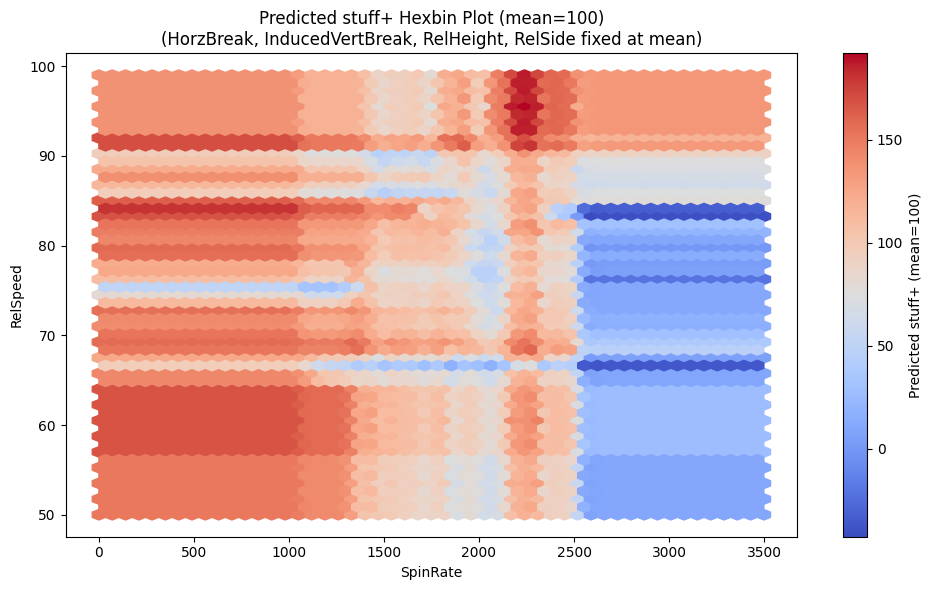

In [172]:
from itertools import product

# Get mean values for the additional features
mean_horzbreak = X['HorzBreak'].mean()
mean_inducedvertbreak = X['InducedVertBreak'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()

# Create grid for SpinRate and RelSpeed, fix other features at their mean
spin_rate = range(0, 3500, 1)
relspeed = range(50, 100, 1)
combinations = list(product(spin_rate, relspeed))

sim_data = pd.DataFrame(combinations, columns=['SpinRate', 'RelSpeed'])
sim_data['HorzBreak'] = mean_horzbreak
sim_data['InducedVertBreak'] = mean_inducedvertbreak
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = xgb_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['SpinRate'],
    sim_data['RelSpeed'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("SpinRate")
plt.ylabel("RelSpeed")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(HorzBreak, InducedVertBreak, RelHeight, RelSide fixed at mean)")
plt.tight_layout()
plt.show()

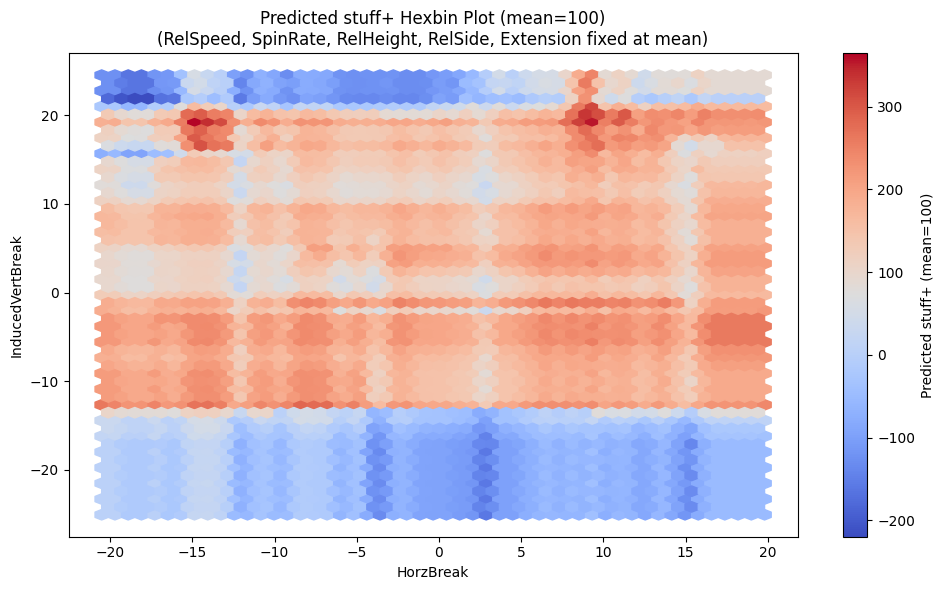

In [173]:
from itertools import product

# Get mean values for the other features
mean_relspeed = X['RelSpeed'].mean()
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()

# Create grid for InducedVertBreak and HorzBreak, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
horz_break = np.linspace(X['HorzBreak'].min(), X['HorzBreak'].max(), 100)
combinations = list(product(induced_vert_break, horz_break))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'HorzBreak'])
sim_data['RelSpeed'] = mean_relspeed
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = xgb_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['HorzBreak'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("HorzBreak")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(RelSpeed, SpinRate, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

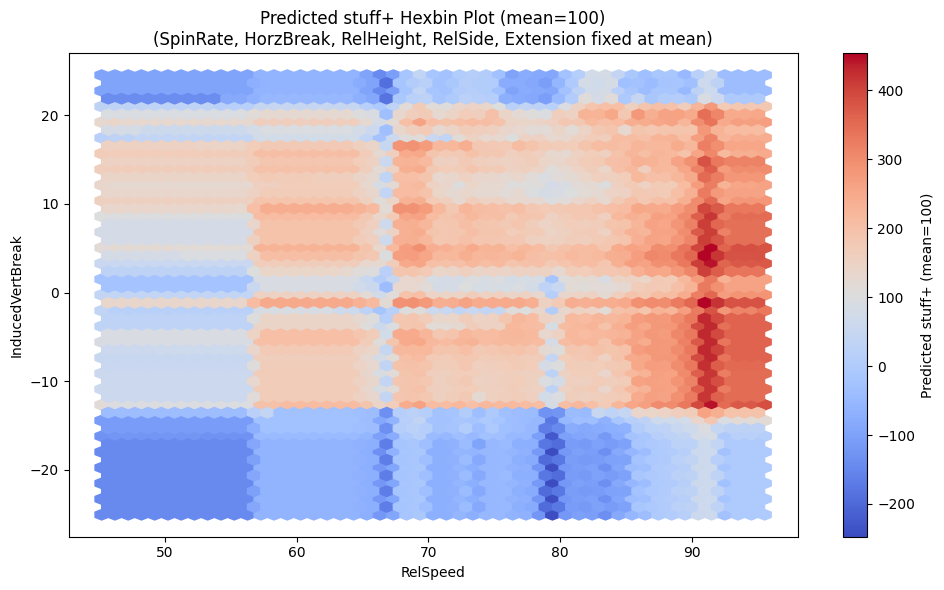

In [174]:
from itertools import product

# Get mean values for the other features
mean_spinrate = X['SpinRate'].mean()
mean_relheight = X['RelHeight'].mean()
mean_relside = X['RelSide'].mean()
mean_extension = X['Extension'].mean()
mean_horzbreak = X['HorzBreak'].mean()

# Create grid for InducedVertBreak and RelSpeed, fix other features at their mean
induced_vert_break = np.linspace(X['InducedVertBreak'].min(), X['InducedVertBreak'].max(), 100)
relspeed = np.linspace(X['RelSpeed'].min(), X['RelSpeed'].max(), 100)
combinations = list(product(induced_vert_break, relspeed))

sim_data = pd.DataFrame(combinations, columns=['InducedVertBreak', 'RelSpeed'])
sim_data['SpinRate'] = mean_spinrate
sim_data['RelHeight'] = mean_relheight
sim_data['RelSide'] = mean_relside
sim_data['Extension'] = mean_extension
sim_data['HorzBreak'] = mean_horzbreak

# Reorder columns to match model input
sim_data = sim_data[['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']]

# Predict and scale
sim_data['PlayResult'] = xgb_model.predict(sim_data)
mean_playresult = sim_data['PlayResult'].mean()
sim_data['PlayResult_scaled'] = sim_data['PlayResult'] * (100 / mean_playresult)

# Hexbin plot for scaled predicted stuff+
plt.figure(figsize=(10, 6))
hb = plt.hexbin(
    sim_data['RelSpeed'],
    sim_data['InducedVertBreak'],
    C=sim_data['PlayResult_scaled'],
    gridsize=50,
    cmap='coolwarm',
    reduce_C_function=np.mean
)
plt.xlabel("RelSpeed")
plt.ylabel("InducedVertBreak")
plt.colorbar(hb, label="Predicted stuff+ (mean=100)")
plt.title("Predicted stuff+ Hexbin Plot (mean=100)\n(SpinRate, HorzBreak, RelHeight, RelSide, Extension fixed at mean)")
plt.tight_layout()

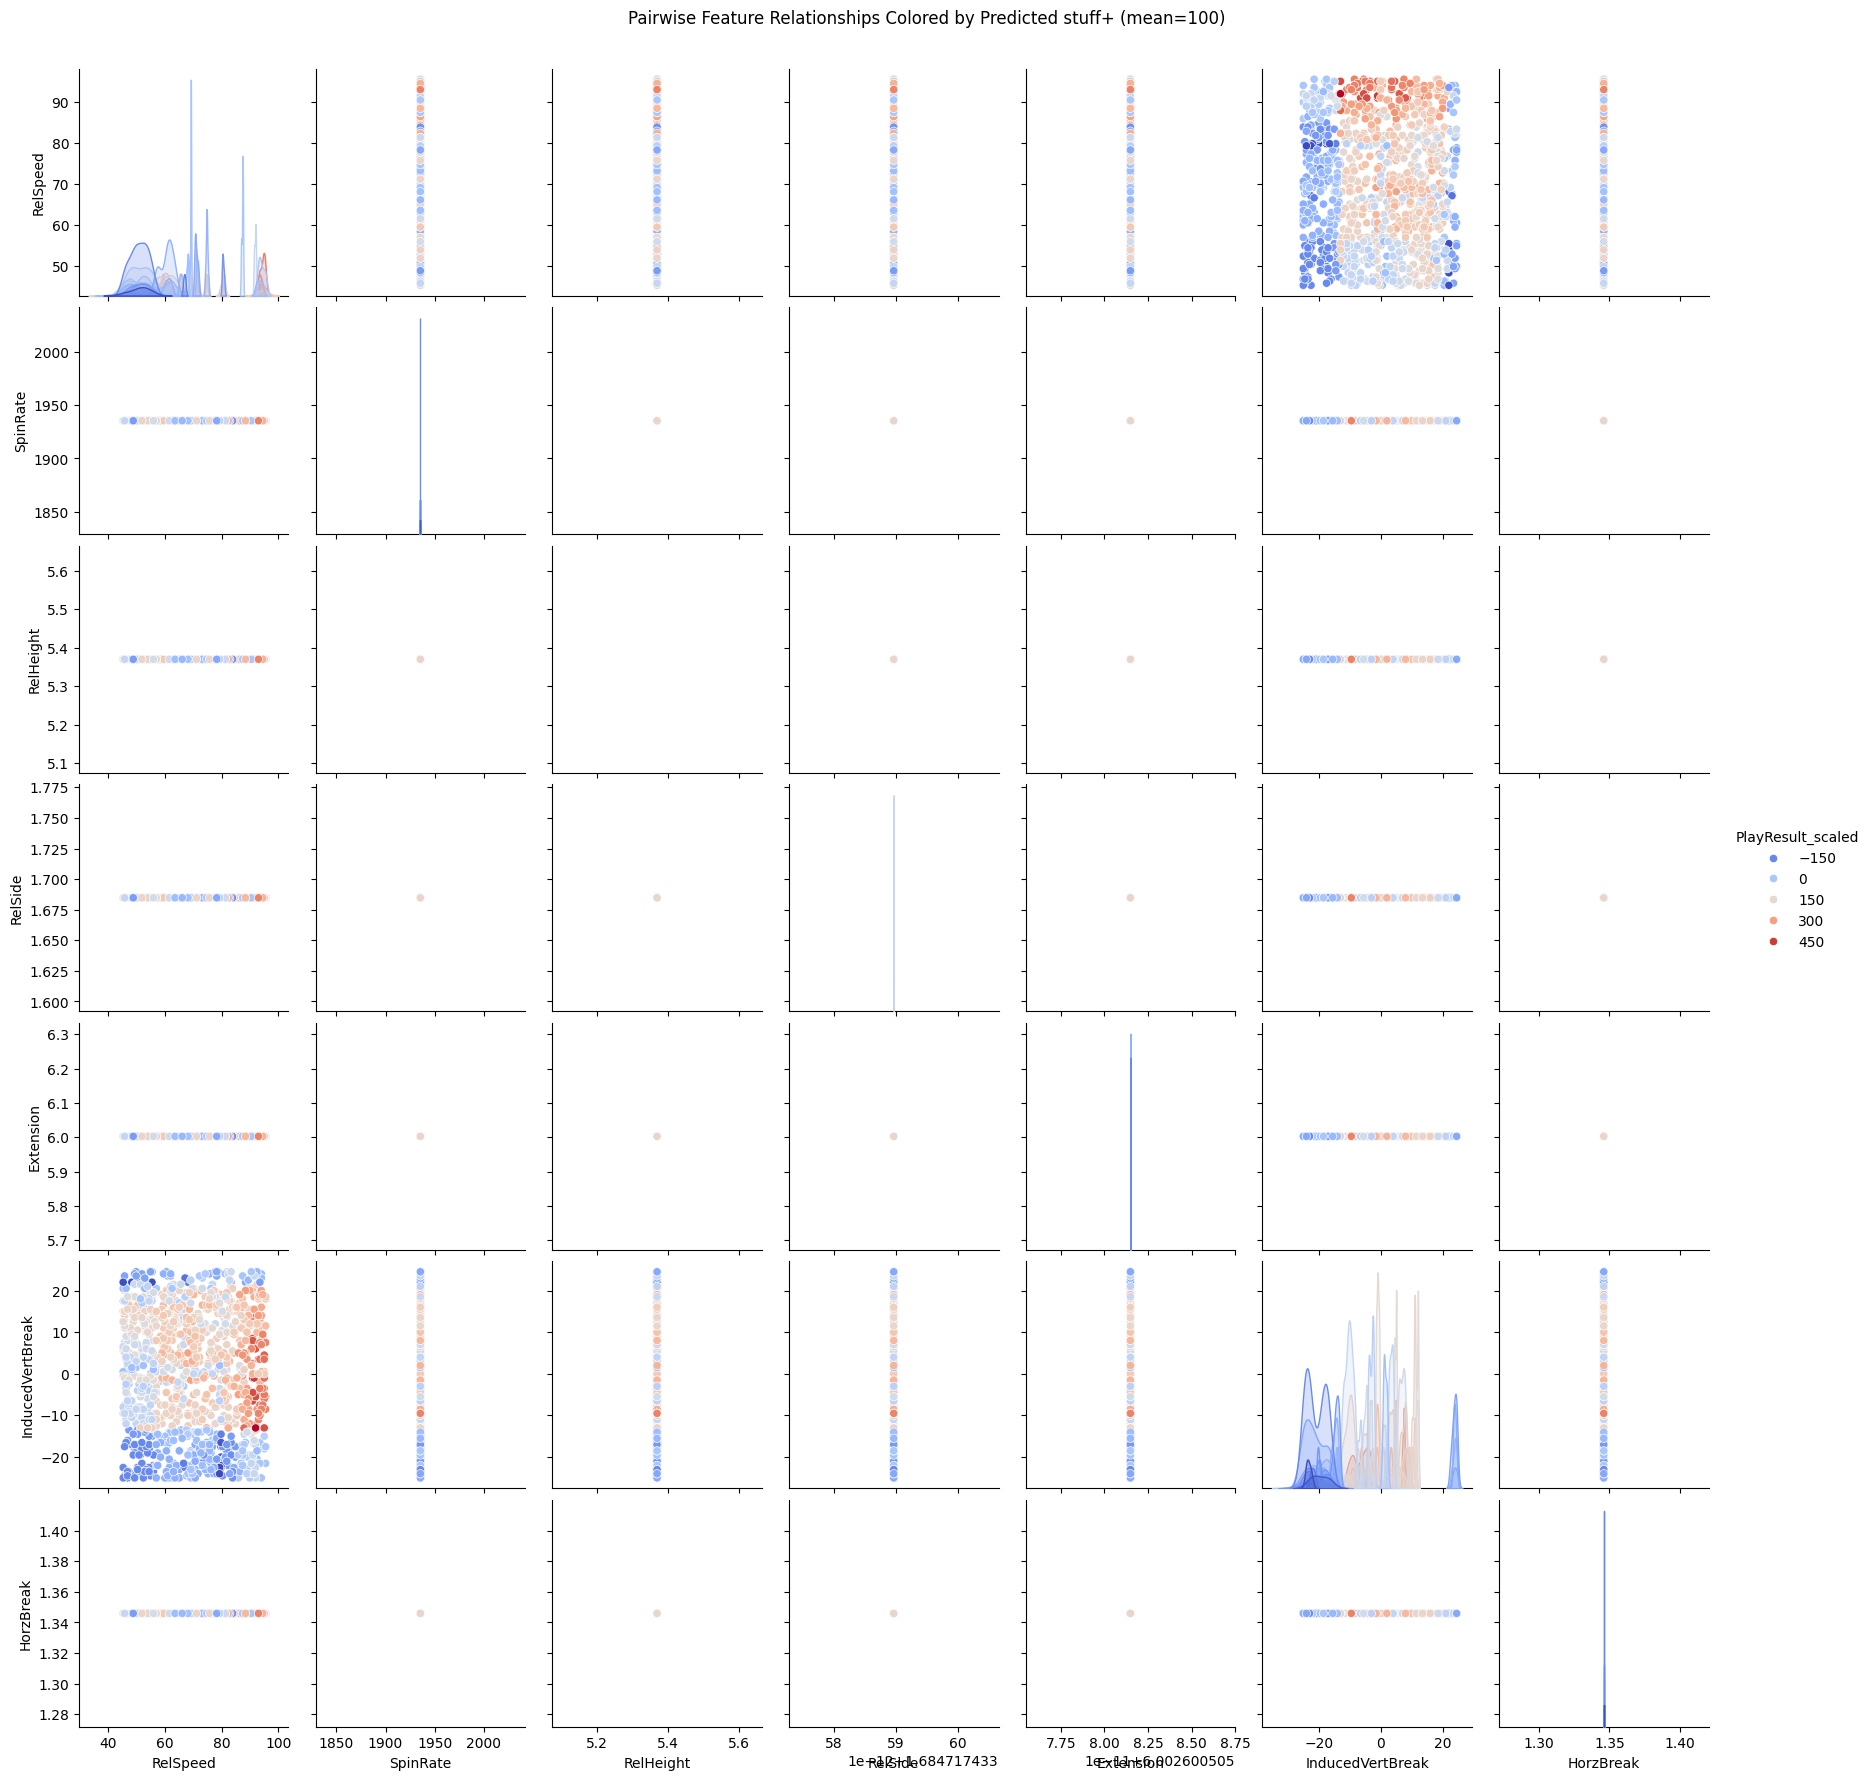

In [175]:
import seaborn as sns

# Sample a subset for visualization if your data is large
sampled = sim_data.sample(n=1000, random_state=42)

# Add the scaled prediction to the DataFrame if not already present
# sampled['PlayResult_scaled'] = sampled['PlayResult'] * (100 / sampled['PlayResult'].mean())

sns.pairplot(sampled, vars=['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak'],
             hue='PlayResult_scaled', palette='coolwarm')
plt.suptitle("Pairwise Feature Relationships Colored by Predicted stuff+ (mean=100)", y=1.02)
plt.show()

In [ ]:
def predict_stuff_plus(event):
    # Make sure all required features are present
    features = ['RelSpeed', 'SpinRate', 'RelHeight', 'RelSide', 'Extension', 'InducedVertBreak', 'HorzBreak']
    if all(f in event and not pd.isna(event[f]) for f in features):
        # Predict using the trained model
        pred = xgb.predict([[event[f] for f in features]])[0]
        # Scale so mean is 100 (use your training mean or pass as argument if needed)
        mean_playresult = y.mean()  # or use a fixed value if you want
        return pred * (100 / 0.5297397769516728)
    else:
        return np.nan  # Not enough data to predict

In [176]:
y.mean()

np.float64(0.5297397769516728)

In [44]:

cornbelters_files = glob.glob("../CornBeltersData/*.csv")
kcl_files = glob.glob("../kclData/*.csv")


# Read and concatenate all CSVs into one DataFrame
cornbelters  = [pd.read_csv(f) for f in cornbelters_files]
kcl = [pd.read_csv(f) for f in kcl_files]
kcl_df = pd.concat(kcl, ignore_index=True)
cornbelters_df = pd.concat(cornbelters, ignore_index=True)

In [45]:
# event should be a dict or Series with the 7 features
import warnings
warnings.filterwarnings("ignore")
kcl_df['stuff+'] = kcl_df.apply(predict_stuff_plus, axis = 1)
cornbelters_df['stuff+'] = cornbelters_df.apply(predict_stuff_plus, axis = 1)
kcl_df.to_csv("kcl_stuff+_data.csv", index=False)
cornbelters_df.to_csv("cornbelters_stuff+_data.csv", index=False)

In [46]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("cornbelters_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("cornbelters_stuff+_pitcher_ranking.csv", index=False)

In [47]:
import pandas as pd

# Load the CSV (replace with your actual file if needed)
df = pd.read_csv("kcl_stuff+_data.csv")

# Filter to only pitches with a valid pitcher name (optional, adjust as needed)
df = df[df['Pitcher'].notna()]

# Calculate mean stuff+ per pitcher
result = (
    df.groupby("Pitcher")
    .agg(
        Pitches=("stuff+", "count"),
        stuff_plus_mean=("stuff+", "mean")
    )
    .reset_index()
)

# Calculate percentile ranking
result["stuff+_percentile"] = result["stuff_plus_mean"].rank(pct=True)

# Sort by stuff+ descending
result = result.sort_values("stuff_plus_mean", ascending=False)

# Show the result
result.to_csv("kcl_stuff+_pitcher_ranking.csv", index=False)

In [23]:
import pickle

In [24]:
with open("stuff_plus_model.pkl", "wb") as f:
    pickle.dump(stuff_plus_model, f)

In [25]:
y.mean()

np.float64(0.5845454545454546)